In [1]:
!pip install -e git+https://github.com/WillSH97/stable_diffusion_explainer.git@utils#egg=SDutils --upgrade

In [21]:
import torch
from tqdm import tqdm
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import requests
from io import BytesIO

from PIL import Image
from torchvision import transforms as tfms
import os

from SDutils import * #importing vars and funcs from previous tutorials 
# NOTE: you may need to restart your session on Google Colab after installing the SDutils package. If you get a ModuleNotFound error for SD_Utils, just try restarting.

# Stable Diffusion explainer!

Hello! welcome to my explainer for stable diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how Latent Diffusion Models work, specifically focusing on Stable Diffusion v1.4, as it's probably the most intuitive to explain. 

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the first section out of 5: a high level explanation of the model cascade. The other sections are accessible here:

1. Intro to the architecture
2. CLIP Text embedder
3. Variational AutoEncoder
4. UNet denoiser
5. Conclusion - putting it all together

*turn these into links eventually*

## Part 5: Putting it all together
Okay, I've shown you a lot of crap at this point - but how does this all fit together?

Well, let's imagine we want to create an image from scratch, based on a text prompt. We currently have loaded:

- a model that can turn text into vector embeddings
- a model that can denoise a latent space, and can be guided by vector embeddings
- a model that can turn a latent space into an image

So, what can we do?

Well, if we try denoising an image that is completely noise, what happens?

In [22]:
# define some functions to reuse

def init_noise(random_seed, scheduler):

    latents = torch.randn(
      (1, 4, 64,64),
        generator=torch.manual_seed(random_seed)
    )
    latents = latents.to(torch_device)
    
    latents = latents * scheduler.init_noise_sigma
    return latents

def LDM_noguide_forward(latents, timestep, scheduler=scheduler):
    latents=latents.half()
    latent_model_input = scheduler.scale_model_input(latents, scheduler.timesteps[timestep]).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(latent_model_input, scheduler.timesteps[timestep], encoder_hidden_states=uncond_embeddings).sample
    
    # output the clean latent
    all_latents=scheduler.step(noise_pred, scheduler.timesteps[timestep], latents)

    return all_latents

In [23]:
#reinitialise scheduler timesteps
scheduler.set_timesteps(5)

#initialise noise
latents=init_noise(random_seed=9001,
                  scheduler=scheduler)

all_latents=LDM_noguide_forward(latents=latents,
                               timestep=0,
                               scheduler=scheduler)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   

denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Weird! when we take completely random noise, denoise it, and then put it through the VAE, you sort of get an extremely blurry looking picture.

Now what happens if we add noise back into the picture, and then denoise it again?

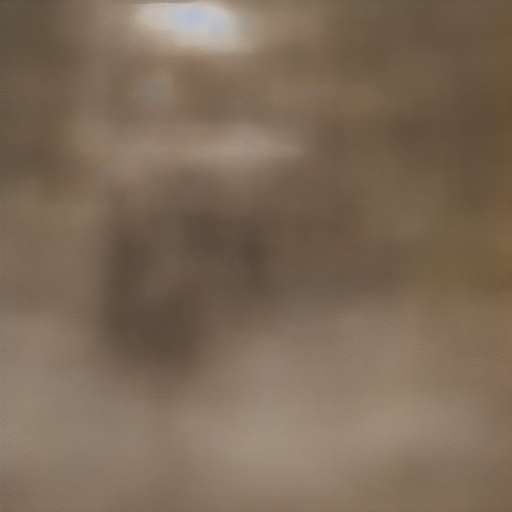

In [24]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=1)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Hmm - slightly more structure... let's do it a few more times


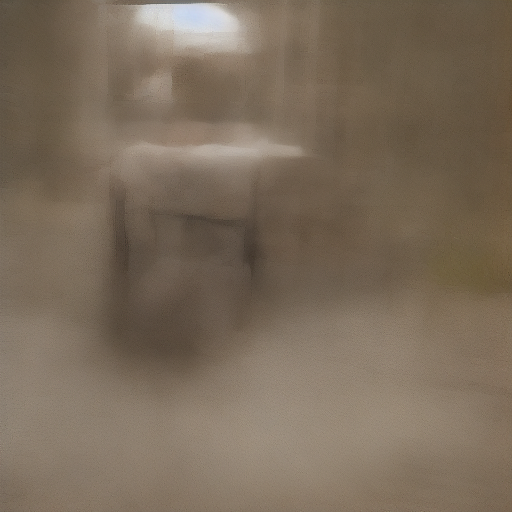

In [25]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=2)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

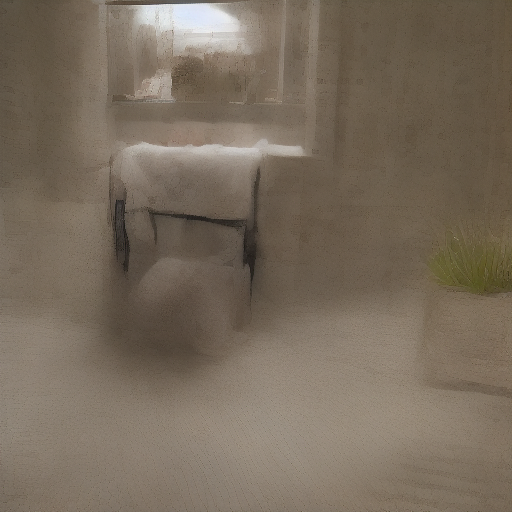

In [26]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=3)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

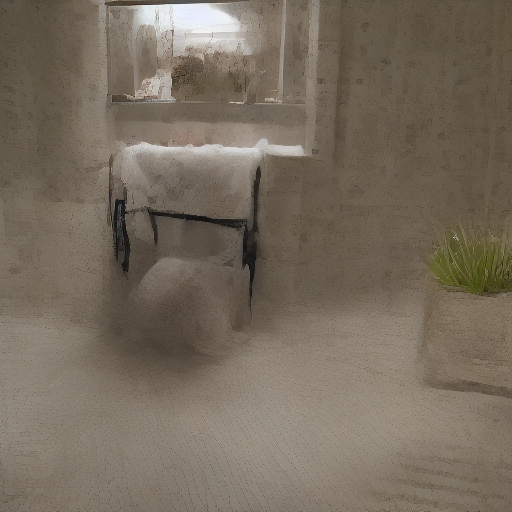

In [27]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=4)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Look at that! That's almost a picture! It sort of looks like a bathroom, with a towel rack, some greenery, and maybe a mirror? very impressionistic.

What's happening here is that every time the image is denoised, a teeny tiny bit of detail is assumed to exist in the leftover image (even though we know for a fact that the image is completely random garbage). The model is iteratively leaving behind bits of what it "assumes" is correct details of the image. 

You can imagine then, that two particular factors play a great role in determining what the model decides to "leave behind" at each step - the initial structure of the noise, and the number of denoising steps it takes. With the initial noise, there will be particular random features within that noise that the model will "leave behind", and with the number of iterations, think of it as the "step size" of the model being slightly smaller, or a sculptor takes bigger or smaller chunks out of a slab of marble at a time. The size and shape of the noise being added will be different at each step, and therefore the detail being left behind will be inherently smaller, but also different as well. 

I'll wrap the above steps into a neat little function for you to iterate over, with those two particular parameters exposed (i.e. you can change them willy nilly). Play around and see what you find!

In [28]:
def seed_timestep_demo(timesteps, seed):

    #reinitialise scheduler timesteps
    scheduler.set_timesteps(timesteps)
    
    #initialise noise
    latents=init_noise(random_seed=seed,
                      scheduler=scheduler)
    
    
    for i in tqdm(range(timesteps)):
        all_latents=LDM_noguide_forward(latents=latents,
                                       timestep=i)
        
        #output image from VAE decoder
        denoised_latents=all_latents.pred_original_sample   
        
        denoisedDecoded=VAE_decode(denoised_latents)
        latents=all_latents.prev_sample
        denoisedDecoded
    return denoisedDecoded

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.93it/s]


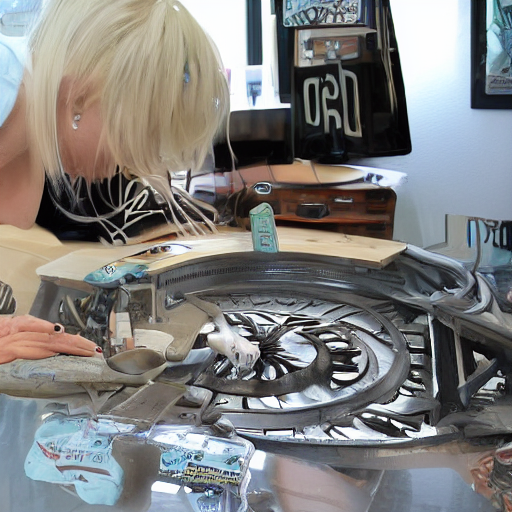

In [29]:
# ITERATE HERE
seed_timestep_demo(timesteps=50,
                  seed=2)

What I've shown you is essentially just the Latent Diffusion model by itself - but how do we add the text in? Well - remember how we put in the empty text embedding for the above exercises? For starters, lets just make that non-empty and see how we go! Have a playaround with the parameters and inputs as well if you like.

In [30]:
def LDM_textonly_forward(latents, timestep, text_embeddings, scheduler=scheduler):
    latents=latents.half()
    latent_model_input = scheduler.scale_model_input(latents, scheduler.timesteps[timestep]).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(latent_model_input, scheduler.timesteps[timestep], encoder_hidden_states=text_embeddings).sample
    
    # output the clean latent
    all_latents=scheduler.step(noise_pred, scheduler.timesteps[timestep], latents)

    return all_latents

def seed_timestep_textinput_demo(timesteps, seed, text_embeddings, scheduler):

    #reinitialise scheduler timesteps
    scheduler.set_timesteps(timesteps)
    
    #initialise noise
    latents=init_noise(random_seed=seed,
                      scheduler=scheduler)
    
    
    for i in tqdm(range(timesteps)):
        all_latents=LDM_textonly_forward(latents=latents,
                                       timestep=i,
                                       text_embeddings=text_embeddings,
                                        scheduler=scheduler)
        
        #output image from VAE decoder
        denoised_latents=all_latents.pred_original_sample   
        
        denoisedDecoded=VAE_decode(denoised_latents)
        latents=all_latents.prev_sample
        denoisedDecoded
    return denoisedDecoded

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]


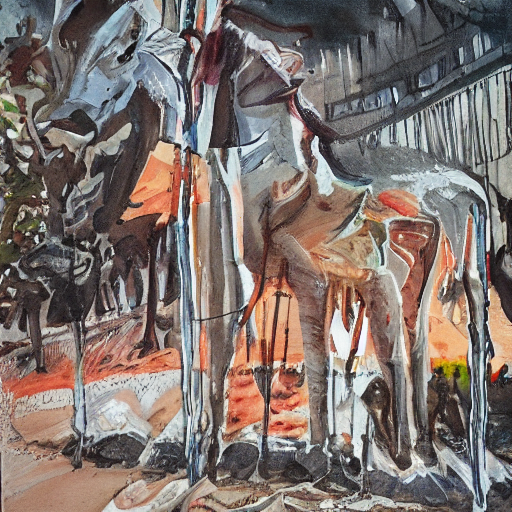

In [31]:
textinput=['Horse']

text_embeddings=sentence_embedder(textinput)[0]

seed_timestep_textinput_demo(timesteps=50,
                             seed=10,
                             text_embeddings=text_embeddings,
                             scheduler=scheduler
                            )

Hmm - interesting. It doesn't seem to be working too well does it? For the most part, it's garbage - Maaaybe it has some little features in the output that look like the text input, but for the most part, it's fairly abstract.

So how do we make it better? Well, some smart folks at Google went "hey, why don't we take the denoised output from the unconditioned diffusion model, and move the conditioned noise prediction further away from the unconditioned prediction?" This technique is called [Classifier-Free Guidance](https://arxiv.org/pdf/2207.12598) - and that's what we're going to do! Let's implement that in code.

In [32]:
def LDM_guided_forward(latents, timestep, text_embeddings, uncond_embeddings, guidance_scale=7.5, scheduler=scheduler):
    
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings]) # batch the conditioned and unconditioned text embeddings
    latents=latents.half()
    latent_model_input=torch.cat([latents] * 2) #make sure latents are the same dimensions as text embeddings
    latent_model_input = scheduler.scale_model_input(latent_model_input, scheduler.timesteps[timestep]).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(latent_model_input, scheduler.timesteps[timestep], encoder_hidden_states=text_embeddings).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # CLASSIFIER-FREE GUIDANCE
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond) 
    
    # output the clean latent
    all_latents=scheduler.step(noise_pred, scheduler.timesteps[timestep], latents)

    return all_latents

def full_demo(timesteps, seed, text_embeddings, uncond_embeddings, guidance_scale=7.5, scheduler=scheduler):

    #reinitialise scheduler timesteps
    scheduler.set_timesteps(timesteps)
    
    #initialise noise
    latents=init_noise(random_seed=seed,
                      scheduler=scheduler)
    
    
    for i in tqdm(range(timesteps)):
        all_latents=LDM_guided_forward(latents=latents,
                                       timestep=i,
                                       text_embeddings=text_embeddings,
                                       uncond_embeddings=uncond_embeddings,
                                       guidance_scale=guidance_scale,
                                       scheduler=scheduler)
        
        #output image from VAE decoder
        denoised_latents=all_latents.pred_original_sample   
        
        denoisedDecoded=VAE_decode(denoised_latents)
        latents=all_latents.prev_sample
    return denoisedDecoded

One thing you'll note is that we also have a guidance scale parameter. In the function written above, you can see that it multiplies the "difference" between the conditioned and unconditioned embeddings, and so you can think of it as amplifying how "conditioned" the generation is going to be. Higher values for the guidance scale should intuitively mean that your output should be more like your text input (i.e. if you put in the word "dog", you would get an image that looks more like a dog) - however, what that means to the diffusion model probably doesn't quite mean what you think! Have a play around below and see what you find!

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.09it/s]


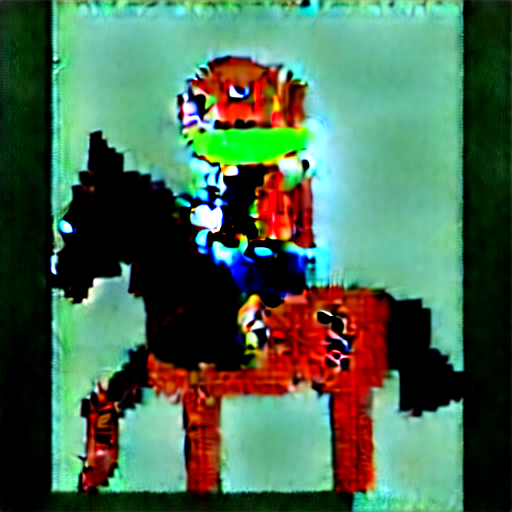

In [47]:
textinput=['an astronaut on a horse']
uncondinput=['']

text_embeddings=sentence_embedder(textinput)[0]
uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=42, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=100, 
          scheduler=scheduler)

And that's it! That's the entirety of the Stable Diffusion model cascade - and we've essentially built it from the ground up! Feel free to have a play around with the cell above - it's the same as all the other Stable Diffusion spaces on the internet, except you now have the satisfaction of having built this one yourself :)

## EXTENSION - playing with inputs
I've noted a few times that we can really think about a lot of these inputs, intermediates, et cetera as sets of numbers that can be manipulated. If you're comfortable with Python, try the following:
- an average of several embedded text inputs
- a linear scaling of text inputs (add a number, multiply, etc)
- ADVANCED - manipulating certain tokens in the embedding
- manipulating the guidance scale

I've got a few examples below of the text input "Owlbear" that I've done some embedding manipulations to - feel free to come up with your own!

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.94it/s]


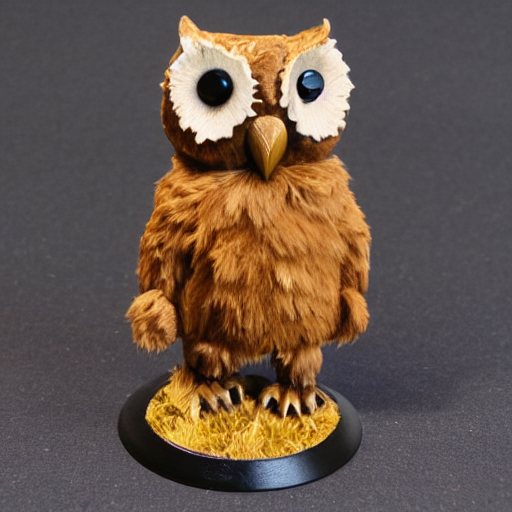

In [34]:
# baseline
textinput=['Owlbear']
uncondinput=['']

text_embeddings=sentence_embedder(textinput)[0]
uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=800, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=7.5, 
          scheduler=scheduler)

In [35]:
# "unconditioned" input is now bear
textinput=['Owlbear']
uncondinput=['bear']

text_embeddings=sentence_embedder(textinput)[0]
uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=800, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=7.5, 
          scheduler=scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.19it/s]


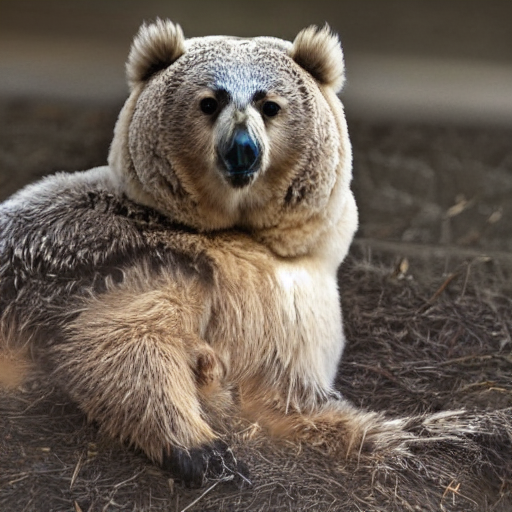

In [48]:
#two text inputs, averaged

textinput=['Owl','bear']
uncondinput=['']

#average text embeddings
text_embeddings=sentence_embedder(textinput)
text_embeddings=text_embeddings[0][0]+text_embeddings[0][1]
text_embeddings=text_embeddings.unsqueeze(0)/2

uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=800, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=7.5, 
          scheduler=scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


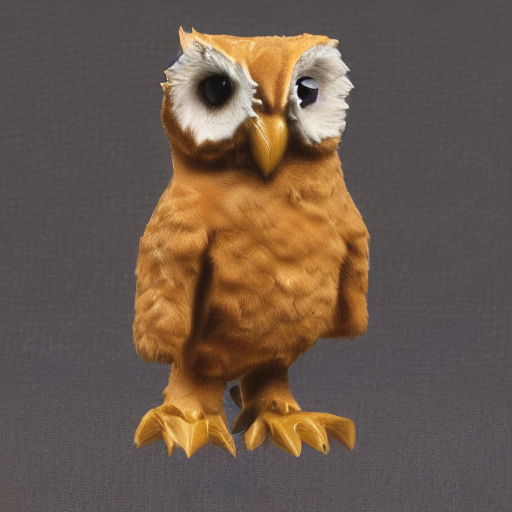

In [41]:
# multiplying the embedding by a constant
textinput=['Owlbear']
uncondinput=['']

text_embeddings=sentence_embedder(textinput)[0] * 0.8
uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=800, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=7.5, 
          scheduler=scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.63it/s]


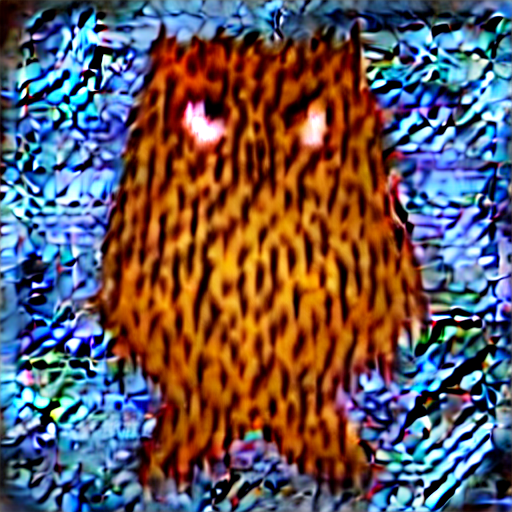

In [43]:
# adding a constant
textinput=['Owlbear']
uncondinput=['']

text_embeddings=sentence_embedder(textinput)[0] + 0.1
uncond_embeddings=sentence_embedder(uncondinput)[0]

full_demo(timesteps=50, 
          seed=800, 
          text_embeddings=text_embeddings, 
          uncond_embeddings=uncond_embeddings, 
          guidance_scale=7.5, 
          scheduler=scheduler)